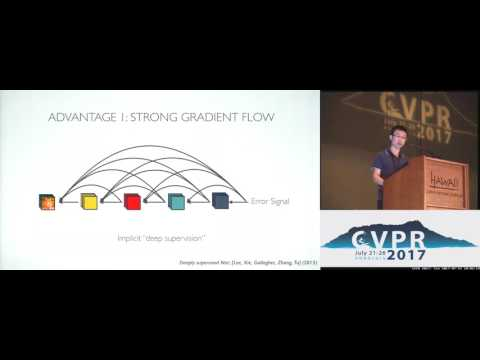

In [1]:
# https://arxiv.org/pdf/1608.06993.pdf

from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id = '-W6y8xnd--U', width = 600)

In [2]:
import tensorflow as tf

In [3]:
# Load CIFAR-10 Dataset

(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
image_height, image_width, channel = X_train.shape[1], X_train.shape[2], X_train.shape[3] 

170500096/170498071 [==============================] - 2s 0us/step


In [4]:
# https://stackoverflow.com/a/49961206/10219869

import numpy
print(numpy.unique(Y_train))
print(len(numpy.unique(Y_train).tolist()))

[0 1 2 3 4 5 6 7 8 9]
10


In [0]:
# Y_train to OHE
Y_train = tf.keras.utils.to_categorical(y = Y_train, num_classes = len(numpy.unique(Y_train).tolist()))
Y_test = tf.keras.utils.to_categorical(y = Y_test, num_classes = len(numpy.unique(Y_test).tolist()))

In [6]:
print('The shape of X_train is:',X_train.shape)
print('The shape of X_test is:',X_test.shape)
print('The shape of Y_train is:',Y_train.shape)
print('The shape of Y_test is:',Y_test.shape)

The shape of X_train is: (50000, 32, 32, 3)
The shape of X_test is: (10000, 32, 32, 3)
The shape of Y_train is: (50000, 10)
The shape of Y_test is: (10000, 10)


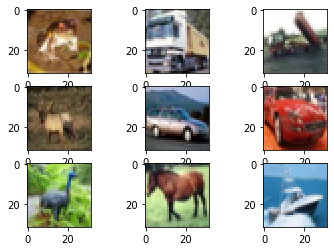

In [7]:
# https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

import matplotlib.pyplot as plt
for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i])
plt.show()


In [0]:
"""ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
                     samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, 
                     width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, 
                     channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, 
                     rescale=None, preprocessing_function=None, data_format='channels_last', validation_split=0.0, 
                     interpolation_order=1, dtype='float32')
"""
batch_size = 128

datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center= False, samplewise_center=False, 
                                      featurewise_std_normalization= False, samplewise_std_normalization=False, 
                                      zca_whitening=False, zca_epsilon=1e-06, rotation_range= 0, width_shift_range=0.1, 
                                      height_shift_range=0.1, brightness_range=None, shear_range=0.0, zoom_range=0.0,
                                      channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip= True, 
                                      vertical_flip=False, rescale=None, preprocessing_function=None, 
                                      data_format= None, validation_split=0.0, dtype='float32')

"""datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./255.)"""

datagen.fit(X_train)

train_datagen = datagen.flow(x = X_train, y = Y_train, batch_size = batch_size)
test_datagen = datagen.flow(x = X_test, y = Y_test, batch_size = batch_size)

In [0]:
compression = 0.5
num_filter = 42

# Dense Block

def dense_block(input, num_filter, dropout_rate = 0):
  global compression
  temp = input

  for _ in range(10):
    Batch_Norm = tf.keras.layers.BatchNormalization()(temp)
    Relu = tf.keras.layers.Activation('relu')(Batch_Norm)
    Conv2D = tf.keras.layers.Conv2D(filters= int(num_filter * compression), kernel_size = (3, 3), padding= 'same',)(Relu)
    if dropout_rate > 0:
      Conv2D = tf.keras.layers.Dropout(dropout_rate)(Conv2D)
    Concat = tf.keras.layers.Concatenate(axis= -1)([temp, Conv2D])
    temp = Concat
  
  return temp



# Transition Block

def transition_block(input, num_filter, dropout_rate = 0):
  global compression
 
  Batch_Norm = tf.keras.layers.BatchNormalization()(input)
  Relu = tf.keras.layers.Activation('relu')(Batch_Norm)
  Conv2D_Bottle_Neck = tf.keras.layers.Conv2D(filters= int(num_filter * compression), kernel_size = (1, 1), padding= 'same',)(Relu)
  if dropout_rate > 0:
      Conv2D_Bottle_Neck = tf.keras.layers.Dropout(dropout_rate)(Conv2D_Bottle_Neck)
  Average_pooling = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides= 2)(Conv2D_Bottle_Neck)
 
  return Average_pooling

    
# Output Layer

def output_layer(input):
  global compression

  Batch_Norm = tf.keras.layers.BatchNormalization()(input)
  Relu = tf.keras.layers.Activation('relu')(Batch_Norm)
  Average_pooling = tf.keras.layers.AveragePooling2D(pool_size = (2, 2))(Relu)
  Conv = tf.keras.layers.Conv2D(filters= 10, kernel_size = (3, 3), padding= 'same', activation = 'softmax')(Average_pooling)
  Global_Max_pooling = tf.keras.layers.GlobalMaxPooling2D()(Conv)
  output = tf.keras.layers.Activation('softmax')(Global_Max_pooling)

  return output


In [0]:
Input = tf.keras.layers.Input(shape = (image_height, image_width, channel))
First_Conv2D = tf.keras.layers.Conv2D(filters= num_filter, kernel_size = (3, 3), padding= 'same')(Input)

First_Block = dense_block(First_Conv2D, num_filter, dropout_rate=0)
First_Transition = transition_block(First_Block, num_filter, dropout_rate=0)

Second_Block = dense_block(First_Transition, num_filter, dropout_rate=0)
Second_Transition = transition_block(Second_Block, num_filter, dropout_rate=0)

Third_Block = dense_block(Second_Transition, num_filter, dropout_rate=0)
Third_Transition = transition_block(Third_Block, num_filter, dropout_rate=0)

Last_Block = dense_block(Third_Transition, num_filter, dropout_rate=0)
output = output_layer(input = Last_Block)

In [22]:
model = tf.keras.models.Model(inputs = [Input], outputs = [output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 32, 32, 42)   1176        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_132 (BatchN (None, 32, 32, 42)   168         conv2d_135[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 32, 32, 42)   0           batch_normalization_132[0][0]    
____________________________________________________________________________________________

In [0]:
# determine loss function and optimizer

model.compile(loss = 'categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'], )

In [24]:
# Resource Exaustion Error, https://github.com/tensorflow/models/issues/1993
batch_size = 128
history = model.fit_generator(generator = train_datagen , steps_per_epoch = numpy.floor(len(X_train) / batch_size), epochs= 200, 
                              validation_data = test_datagen  )

Epoch 1/200
390/390 [==============================] - 79s 203ms/step - loss: 1.9381 - acc: 0.3856 - val_loss: 2.1845 - val_acc: 0.2135
Epoch 2/200
390/390 [==============================] - 63s 162ms/step - loss: 1.8287 - acc: 0.4956 - val_loss: 1.9634 - val_acc: 0.3894
Epoch 3/200
390/390 [==============================] - 63s 162ms/step - loss: 1.7715 - acc: 0.5739 - val_loss: 1.8381 - val_acc: 0.5090
Epoch 4/200
390/390 [==============================] - 63s 161ms/step - loss: 1.7341 - acc: 0.6280 - val_loss: 1.7700 - val_acc: 0.5879
Epoch 5/200
390/390 [==============================] - 63s 161ms/step - loss: 1.6999 - acc: 0.6651 - val_loss: 1.7660 - val_acc: 0.5884
Epoch 6/200
390/390 [==============================] - 63s 161ms/step - loss: 1.6790 - acc: 0.6856 - val_loss: 1.7192 - val_acc: 0.6485
Epoch 7/200
390/390 [==============================] - 63s 161ms/step - loss: 1.6658 - acc: 0.7002 - val_loss: 1.8189 - val_acc: 0.5402
Epoch 8/200
390/390 [===========================

In [0]:
# We save the model

model.save('model_dense')

10000/10000 [==============================] - 5s 500us/sample - loss: 1.5389 - acc: 0.9023
Test Loss: 1.5389170993804933

Test Accuracy: 0.9023


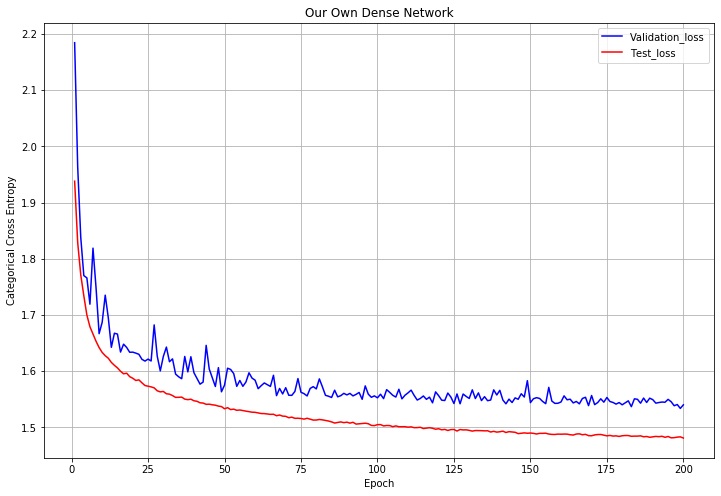

In [28]:
import matplotlib.pyplot as plt

score = model.evaluate(x= X_test, y= Y_test)
print('Test Loss:', score[0])
print()
print('Test Accuracy:', score[1])

def plt_dynamic(x, val_y, test_y, ax, color='b'):
  ax.plot(x, val_y, 'b', label = 'Validation_loss')
  ax.plot(x, test_y, 'r', label = 'Test_loss')
  plt.grid()
  plt.legend()
  fig.canvas.draw()

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.set_xlabel('Epoch')
ax.set_ylabel('Categorical Cross Entropy')
plt.title('Our Own Dense Network')

x = list(range(1, 201))
val_y = history.history['val_loss']
test_y = history.history['loss']

plt_dynamic(x, val_y, test_y, ax)